# Introduction

There's always a desire within me to somehow pry into a neural network and see what's happening from layer to layer. It's  hard to do this though when the feature map at some depth has a very large number of channels, because we don't know which channel to look at. 

In this toy example, we'll train some classifiers on two dimensional data. We'll choose our network to compress and expand in successive layers, so that at the bottlenecks we'll have two nodes, which we'll treat as some $(\hat{x}, \hat{y})$ that is the result of the transformation the network (up to that point) performs on the input $(x,y)$. We can then plot them! 

I'm hoping that we see points in different classes migrate further away from each other as we inspect deeper bottleneck layers in our network. It will also be a question as to whether or not a network with this architecture will work (as each bottleneck will probably hurt the architecture's discriminatory ability), but hopefully since we're only doing binary classification, a two-node bottleneck will still have sufficient bandwith.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Data

There are a bunch of cool 2d datasets we can use for these experiments, thanks to sklearn. Let's take a look at some.

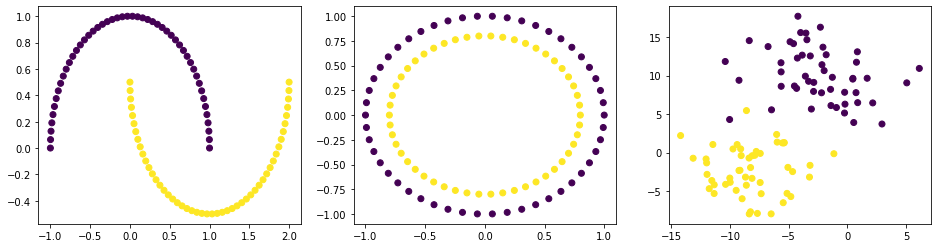

In [ ]:
from sklearn.datasets import make_circles, make_moons, make_blobs

def plot_toy_data(data, labels):
  plt.scatter(data[:,0], data[:,1], marker='o', c=labels)


moons, moons_labels = make_moons()
plt.figure(figsize=(16,4))
plt.subplot(131)
plot_toy_data(moons, moons_labels)
# plt.scatter(moons[:,0], moons[:,1], marker='o', c=moons_labels)
circles, circles_labels = make_circles()
plt.subplot(132)
plot_toy_data(circles, circles_labels)
plt.subplot(133)
blobs, blobs_labels = make_blobs(centers=2, cluster_std=3)
plot_toy_data(blobs, blobs_labels)

# Architecture

nothing fancy, just an mlp with some bottleneck layers interpsersed. 

We can think of this general architecture as a series of blocks, where each block consists of two layers with the number of nodes equal to the parameter 'width', followed by a bottleneck layer of two nodes. The number of these blocks we have is given by the parameter 'depth'.

In [ ]:
class BottleneckMLP(nn.Module):
  def bottleneck_block(self, width, activation=nn.ReLU()):
    return nn.Sequential(nn.Linear(2, width), nn.ReLU(), 
                         nn.Linear(width, width), nn.ReLU(), 
                         nn.Linear(width, 2), activation)

    # name = 'block_{}_'.format(i)
    # self.main.add_module(name+'lin1',nn.Linear(2, self.width))
    # self.main.add_module(name+'relu1', nn.ReLU())
    # self.main.add_module(name+'lin2', nn.Linear(width, width)
    # self.main.add_module(name+'relu2', nn.ReLU())
    # self.main.add_module(name+'lin3', nn.Linear(width, 2)
    # self.main.add_module() activation)

  def __init__(self, width=10, depth=2):
    super(BottleneckMLP, self).__init__()
    self.blocks = [self.bottleneck_block(width)] * depth
    self.params = []
    for block in self.blocks:
      self.params += list(block.parameters())

  def parameters(self):
    return nn.ParameterList(self.params)
    
  def forward(self, x):
    check_pts = []
    for block in self.blocks:
      x = block(x)
      check_pts.append(x)
    return check_pts

net = BottleneckMLP()

In [ ]:
def train(data, labels, epochs=1000):
  x = torch.Tensor(data)
  y = torch.LongTensor(labels)
  net = BottleneckMLP()
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.0005)

  for epoch in range(epochs):
    optimizer.zero_grad()
    output = net(x)
    loss = criterion(output[-1], y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
      print('Epoch: {}......Loss: {:.4f}'.format(epoch, loss.item()))
    if epoch % 200 == 0:
      print(epoch)
      plt.figure(figsize=(16,4))
      plt.subplot(131)
      plot_toy_data(data, labels)
      plt.subplot(132)
      plot_toy_data(output[0].detach().numpy(), labels)
      plt.subplot(133)
      plot_toy_data(output[1].detach().numpy(), labels)
      plt.show()
      plot_boundary_in_original_space(net, data, labels)
  
  return net

Epoch: 0......Loss: 0.6938
0


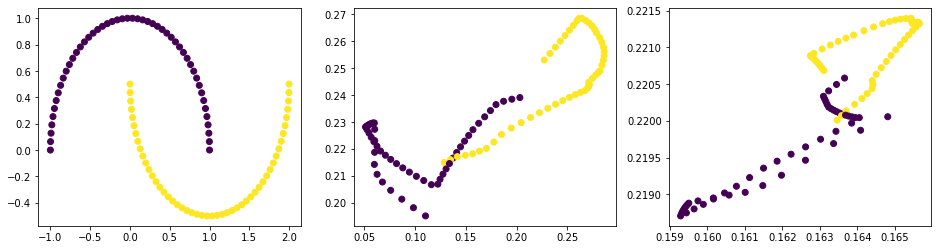

Epoch: 20......Loss: 0.6891
Epoch: 40......Loss: 0.6791
Epoch: 60......Loss: 0.6582
Epoch: 80......Loss: 0.6307
Epoch: 100......Loss: 0.5900
Epoch: 120......Loss: 0.5488
Epoch: 140......Loss: 0.5119
Epoch: 160......Loss: 0.4799
Epoch: 180......Loss: 0.4448
Epoch: 200......Loss: 0.4061
200


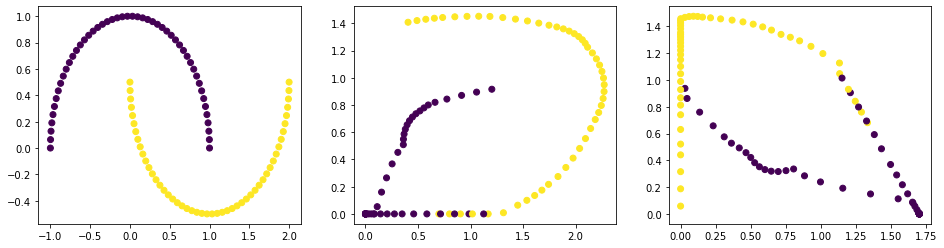

Epoch: 220......Loss: 0.3744
Epoch: 240......Loss: 0.3440
Epoch: 260......Loss: 0.3060
Epoch: 280......Loss: 0.2598
Epoch: 300......Loss: 0.2091
Epoch: 320......Loss: 0.1601
Epoch: 340......Loss: 0.1238
Epoch: 360......Loss: 0.0950
Epoch: 380......Loss: 0.0742
Epoch: 400......Loss: 0.0554
400


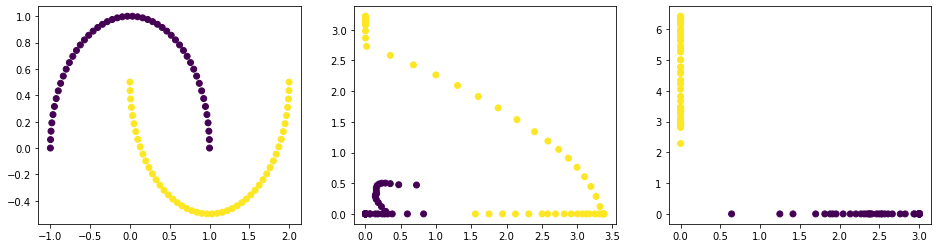

Epoch: 420......Loss: 0.0442
Epoch: 440......Loss: 0.0362
Epoch: 460......Loss: 0.0300
Epoch: 480......Loss: 0.0252
Epoch: 500......Loss: 0.0214
Epoch: 520......Loss: 0.0183
Epoch: 540......Loss: 0.0158
Epoch: 560......Loss: 0.0136
Epoch: 580......Loss: 0.0119
Epoch: 600......Loss: 0.0105
600


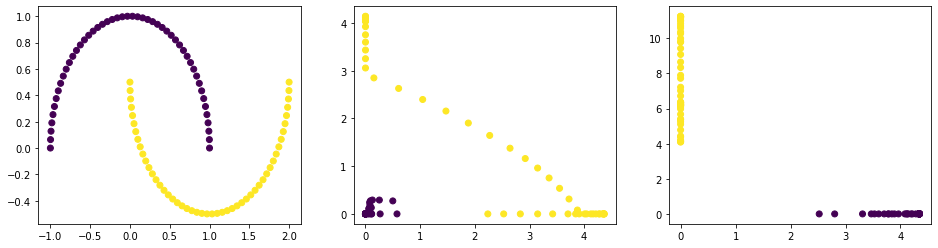

Epoch: 620......Loss: 0.0093
Epoch: 640......Loss: 0.0083
Epoch: 660......Loss: 0.0074
Epoch: 680......Loss: 0.0067
Epoch: 700......Loss: 0.0061
Epoch: 720......Loss: 0.0055
Epoch: 740......Loss: 0.0051
Epoch: 760......Loss: 0.0046
Epoch: 780......Loss: 0.0043
Epoch: 800......Loss: 0.0039
800


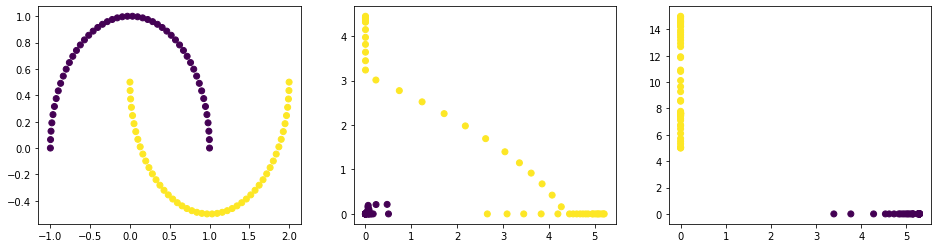

Epoch: 820......Loss: 0.0036
Epoch: 840......Loss: 0.0033
Epoch: 860......Loss: 0.0031
Epoch: 880......Loss: 0.0029
Epoch: 900......Loss: 0.0027
Epoch: 920......Loss: 0.0025
Epoch: 940......Loss: 0.0023
Epoch: 960......Loss: 0.0022
Epoch: 980......Loss: 0.0021


In [ ]:
moons_net = train(moons, moons_labels)

------------------------------------------------------------
Epoch: 0......Loss: 0.6980
0


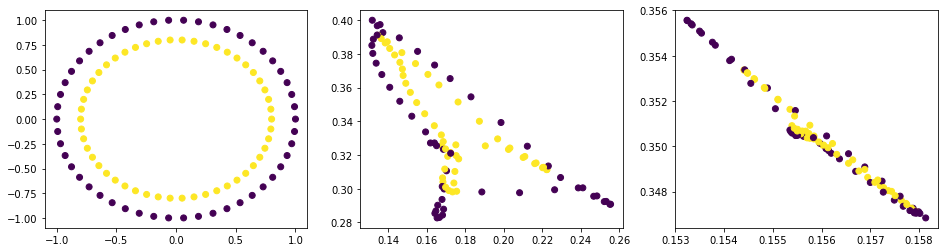

Epoch: 20......Loss: 0.6933
Epoch: 40......Loss: 0.6931
Epoch: 60......Loss: 0.6930
Epoch: 80......Loss: 0.6929
Epoch: 100......Loss: 0.6922
Epoch: 120......Loss: 0.6904
Epoch: 140......Loss: 0.6861
Epoch: 160......Loss: 0.6808
Epoch: 180......Loss: 0.6746
Epoch: 200......Loss: 0.6665
200


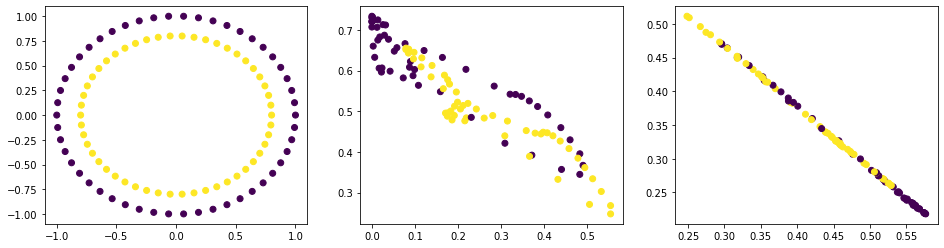

Epoch: 220......Loss: 0.6546
Epoch: 240......Loss: 0.6356
Epoch: 260......Loss: 0.5972
Epoch: 280......Loss: 0.4975
Epoch: 300......Loss: 0.3393
Epoch: 320......Loss: 0.2317
Epoch: 340......Loss: 0.1808
Epoch: 360......Loss: 0.1493
Epoch: 380......Loss: 0.1227
Epoch: 400......Loss: 0.1011
400


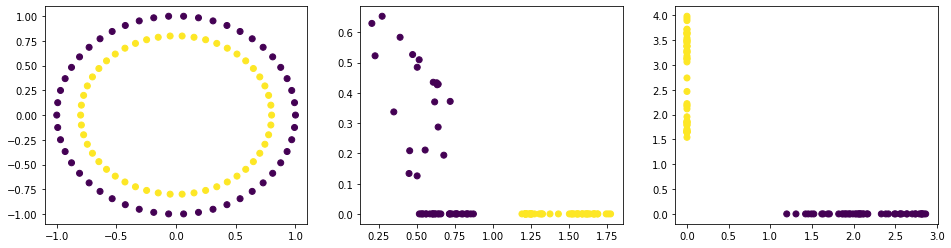

Epoch: 420......Loss: 0.0831
Epoch: 440......Loss: 0.0676
Epoch: 460......Loss: 0.0521
Epoch: 480......Loss: 0.0421
Epoch: 500......Loss: 0.0348
Epoch: 520......Loss: 0.0293
Epoch: 540......Loss: 0.0251
Epoch: 560......Loss: 0.0218
Epoch: 580......Loss: 0.0191
Epoch: 600......Loss: 0.0169
600


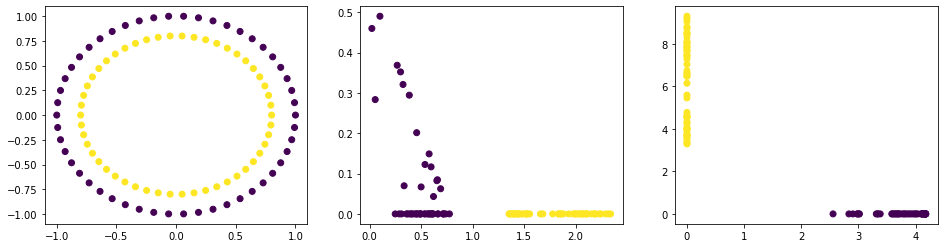

Epoch: 620......Loss: 0.0151
Epoch: 640......Loss: 0.0135
Epoch: 660......Loss: 0.0122
Epoch: 680......Loss: 0.0111
Epoch: 700......Loss: 0.0101
Epoch: 720......Loss: 0.0092
Epoch: 740......Loss: 0.0084
Epoch: 760......Loss: 0.0077
Epoch: 780......Loss: 0.0071
Epoch: 800......Loss: 0.0066
800


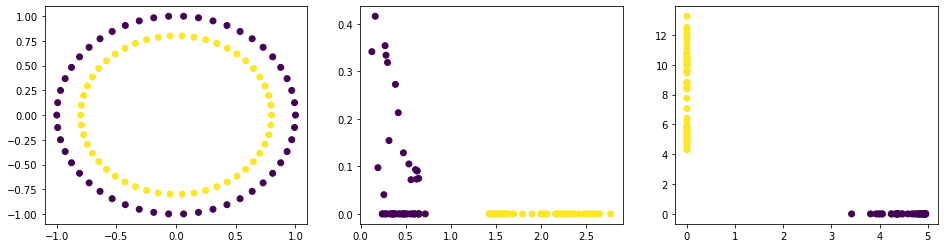

Epoch: 820......Loss: 0.0061
Epoch: 840......Loss: 0.0057
Epoch: 860......Loss: 0.0053
Epoch: 880......Loss: 0.0050
Epoch: 900......Loss: 0.0046
Epoch: 920......Loss: 0.0044
Epoch: 940......Loss: 0.0041
Epoch: 960......Loss: 0.0039
Epoch: 980......Loss: 0.0036


In [ ]:
print('-'*60)
circles_net = train(circles, circles_labels)

------------------------------------------------------------
Epoch: 0......Loss: 0.6879
0


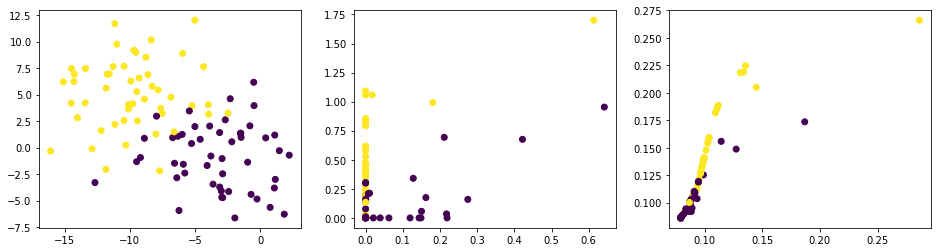

Epoch: 20......Loss: 0.6580
Epoch: 40......Loss: 0.5811
Epoch: 60......Loss: 0.4976
Epoch: 80......Loss: 0.4514
Epoch: 100......Loss: 0.4051
Epoch: 120......Loss: 0.3493
Epoch: 140......Loss: 0.2968
Epoch: 160......Loss: 0.2532
Epoch: 180......Loss: 0.2224
Epoch: 200......Loss: 0.2033
200


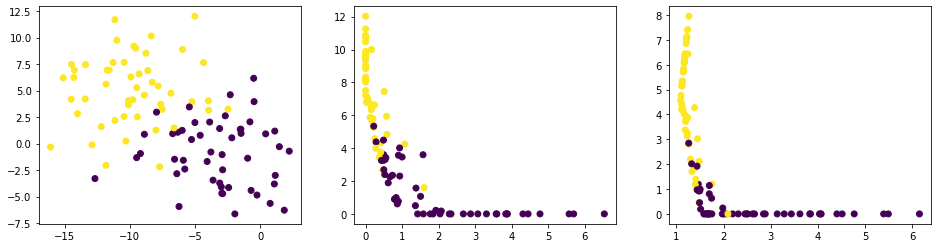

Epoch: 220......Loss: 0.1923
Epoch: 240......Loss: 0.1855
Epoch: 260......Loss: 0.1801
Epoch: 280......Loss: 0.1765
Epoch: 300......Loss: 0.1729
Epoch: 320......Loss: 0.1711
Epoch: 340......Loss: 0.1691
Epoch: 360......Loss: 0.1675
Epoch: 380......Loss: 0.1664
Epoch: 400......Loss: 0.1655
400


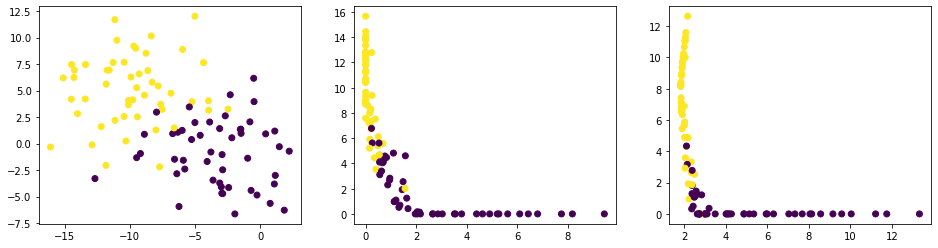

Epoch: 420......Loss: 0.1640
Epoch: 440......Loss: 0.1626
Epoch: 460......Loss: 0.1611
Epoch: 480......Loss: 0.1594
Epoch: 500......Loss: 0.1580
Epoch: 520......Loss: 0.1558
Epoch: 540......Loss: 0.1553
Epoch: 560......Loss: 0.1535
Epoch: 580......Loss: 0.1527
Epoch: 600......Loss: 0.1526
600


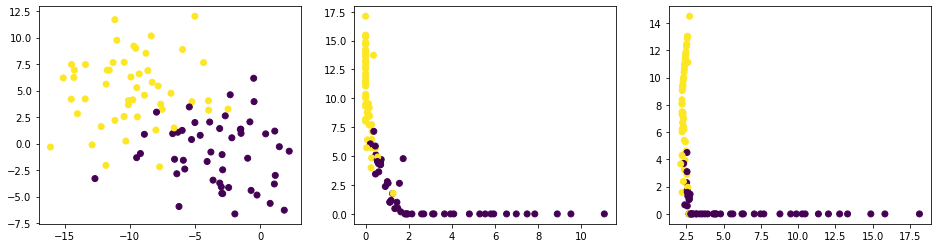

Epoch: 620......Loss: 0.1480
Epoch: 640......Loss: 0.1478
Epoch: 660......Loss: 0.1454
Epoch: 680......Loss: 0.1437
Epoch: 700......Loss: 0.1418
Epoch: 720......Loss: 0.1402
Epoch: 740......Loss: 0.1385
Epoch: 760......Loss: 0.1353
Epoch: 780......Loss: 0.1353
Epoch: 800......Loss: 0.1339
800


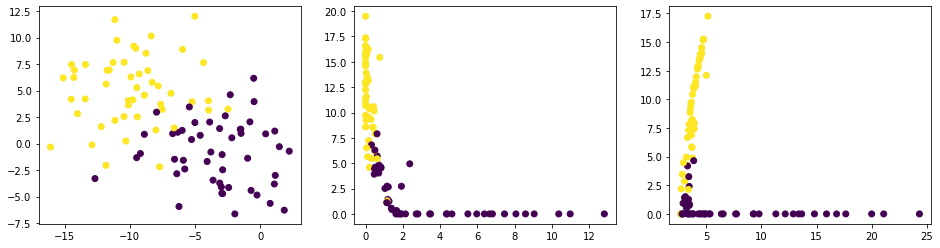

Epoch: 820......Loss: 0.1337
Epoch: 840......Loss: 0.1297
Epoch: 860......Loss: 0.1329
Epoch: 880......Loss: 0.1296
Epoch: 900......Loss: 0.1268
Epoch: 920......Loss: 0.1246
Epoch: 940......Loss: 0.1233
Epoch: 960......Loss: 0.1220
Epoch: 980......Loss: 0.1206
Epoch: 1000......Loss: 0.1196
1000


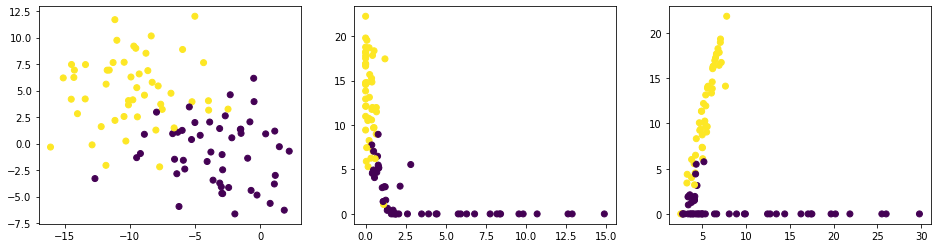

Epoch: 1020......Loss: 0.1187
Epoch: 1040......Loss: 0.1195
Epoch: 1060......Loss: 0.1199
Epoch: 1080......Loss: 0.1164
Epoch: 1100......Loss: 0.1144
Epoch: 1120......Loss: 0.1149
Epoch: 1140......Loss: 0.1169
Epoch: 1160......Loss: 0.1164
Epoch: 1180......Loss: 0.1117
Epoch: 1200......Loss: 0.1092
1200


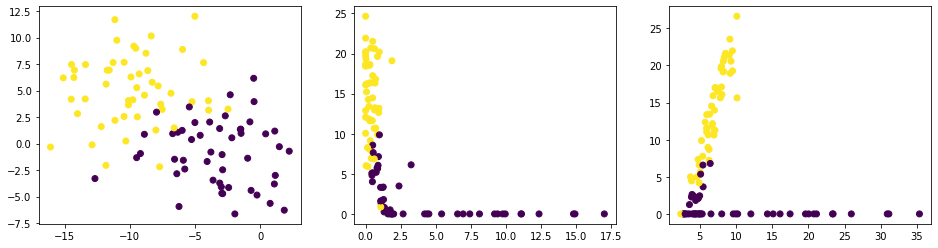

Epoch: 1220......Loss: 0.1079
Epoch: 1240......Loss: 0.1074
Epoch: 1260......Loss: 0.1068
Epoch: 1280......Loss: 0.1064
Epoch: 1300......Loss: 0.1080
Epoch: 1320......Loss: 0.1106
Epoch: 1340......Loss: 0.1058
Epoch: 1360......Loss: 0.1032
Epoch: 1380......Loss: 0.1025
Epoch: 1400......Loss: 0.1009
1400


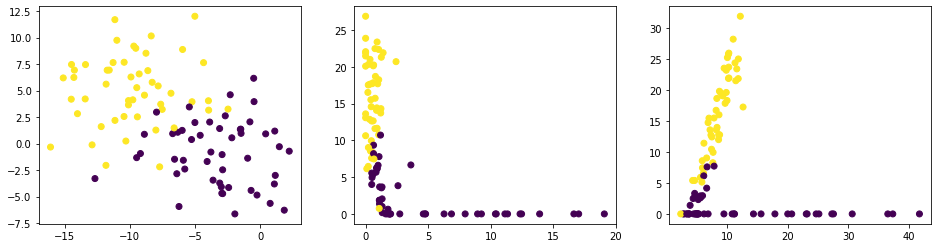

Epoch: 1420......Loss: 0.1005
Epoch: 1440......Loss: 0.0991
Epoch: 1460......Loss: 0.1000
Epoch: 1480......Loss: 0.0994
Epoch: 1500......Loss: 0.0986
Epoch: 1520......Loss: 0.0964
Epoch: 1540......Loss: 0.0949
Epoch: 1560......Loss: 0.0951
Epoch: 1580......Loss: 0.0936
Epoch: 1600......Loss: 0.0937
1600


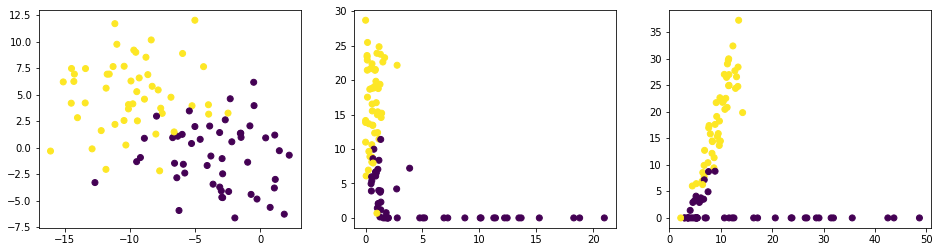

Epoch: 1620......Loss: 0.0962
Epoch: 1640......Loss: 0.0954
Epoch: 1660......Loss: 0.0940
Epoch: 1680......Loss: 0.0908
Epoch: 1700......Loss: 0.0917
Epoch: 1720......Loss: 0.0918
Epoch: 1740......Loss: 0.0919
Epoch: 1760......Loss: 0.0937
Epoch: 1780......Loss: 0.0915
Epoch: 1800......Loss: 0.0942
1800


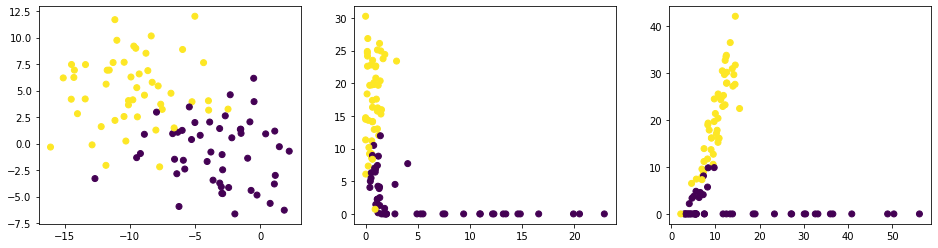

Epoch: 1820......Loss: 0.0930
Epoch: 1840......Loss: 0.0910
Epoch: 1860......Loss: 0.0930
Epoch: 1880......Loss: 0.0901
Epoch: 1900......Loss: 0.0887
Epoch: 1920......Loss: 0.0891
Epoch: 1940......Loss: 0.0862
Epoch: 1960......Loss: 0.0850
Epoch: 1980......Loss: 0.0840


In [ ]:
print('-'*60)
blobs_net = train(blobs, blobs_labels, epochs=2000)

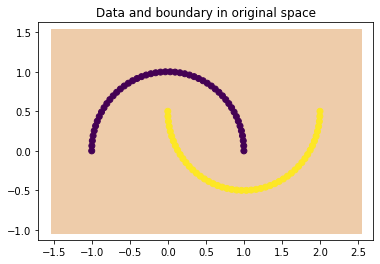

NameError: ignored

In [ ]:
def plot_boundary_in_original_space(model, X, labels):
    grid_density = 100
    x1 = np.linspace(X[:,0].min()-0.5,X[:,0].max()+0.5,grid_density)
    x2 = np.linspace(X[:,1].min()-0.5,X[:,1].max()+0.5,grid_density)
    mash = np.meshgrid(x1,x2)
    n=2

    data_tmp = np.ndarray((grid_density**2, n))
    data_tmp[:,0] = mash[0].flatten()
    data_tmp[:,1] = mash[1].flatten()
    data_tmp_tensor = torch.tensor(data_tmp, dtype=torch.float32)

    preds = model(data_tmp_tensor)[-1].detach().numpy()
    c0 = data_tmp[preds[:,0] > preds[:,1]]
    c1 = data_tmp[preds[:,0] <= preds[:,1]]
    plt.scatter(c0[:,0],c0[:,1], alpha=1.0, marker='s', color="#aaccee")
    plt.scatter(c1[:,0],c1[:,1], alpha=1.0, marker='s', color="#eeccaa")
    plot_toy_data(X, labels)
    plt.title('Data and boundary in original space')
    plt.show()

plot_boundary_in_original_space(moons_net, X=moons, labels=moons_labels)
plot_boundary_in_original_space(circles_net, X=circles, labels=circles_labels)
plot_boundary_in_original_space(blobs_net, X=blobs, labels=blobs_labels)

Epoch: 0......Loss: 0.6939
0


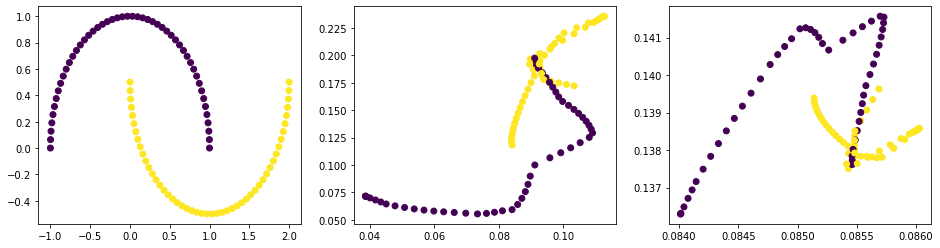

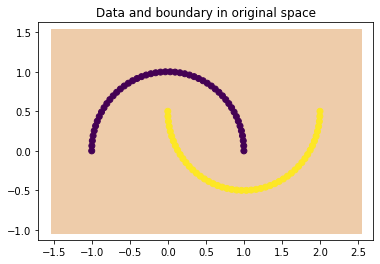

Epoch: 20......Loss: 0.6916
Epoch: 40......Loss: 0.6889
Epoch: 60......Loss: 0.6816
Epoch: 80......Loss: 0.6674
Epoch: 100......Loss: 0.6460
Epoch: 120......Loss: 0.6164
Epoch: 140......Loss: 0.5751
Epoch: 160......Loss: 0.5267
Epoch: 180......Loss: 0.4825
Epoch: 200......Loss: 0.4430
200


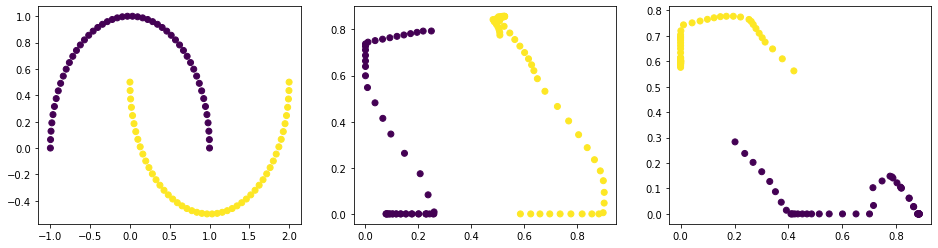

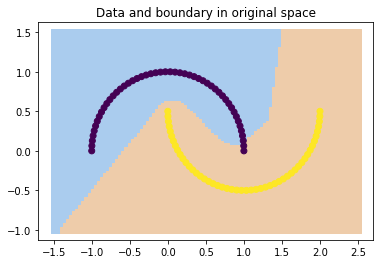

Epoch: 220......Loss: 0.4108
Epoch: 240......Loss: 0.3847
Epoch: 260......Loss: 0.3602
Epoch: 280......Loss: 0.3390
Epoch: 300......Loss: 0.3185
Epoch: 320......Loss: 0.2988
Epoch: 340......Loss: 0.2796
Epoch: 360......Loss: 0.2576
Epoch: 380......Loss: 0.2326
Epoch: 400......Loss: 0.2049
400


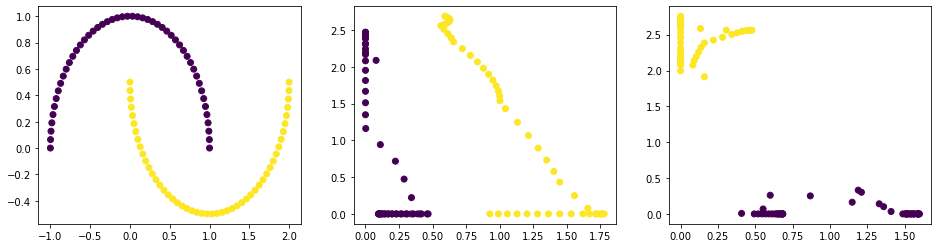

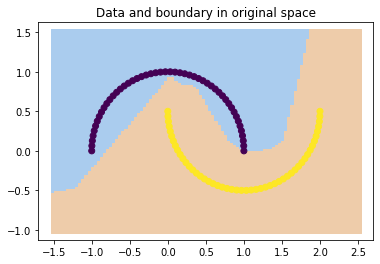

Epoch: 420......Loss: 0.1674
Epoch: 440......Loss: 0.1333
Epoch: 460......Loss: 0.1070
Epoch: 480......Loss: 0.0887
Epoch: 500......Loss: 0.0750
Epoch: 520......Loss: 0.0647
Epoch: 540......Loss: 0.0569
Epoch: 560......Loss: 0.0512
Epoch: 580......Loss: 0.0462
Epoch: 600......Loss: 0.0421
600


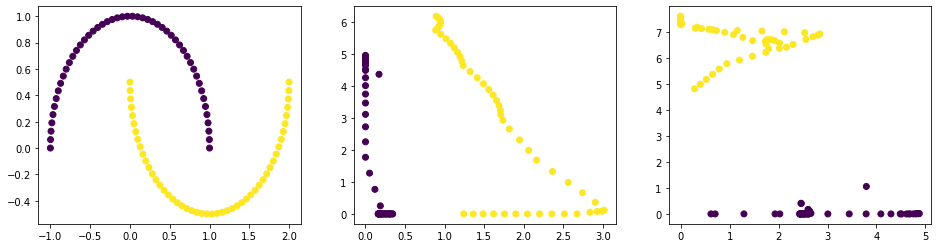

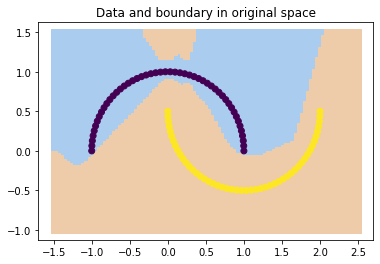

Epoch: 620......Loss: 0.0387
Epoch: 640......Loss: 0.0359
Epoch: 660......Loss: 0.0328
Epoch: 680......Loss: 0.0299
Epoch: 700......Loss: 0.0274
Epoch: 720......Loss: 0.0259
Epoch: 740......Loss: 0.0246
Epoch: 760......Loss: 0.0226
Epoch: 780......Loss: 0.0218
Epoch: 800......Loss: 0.0207
800


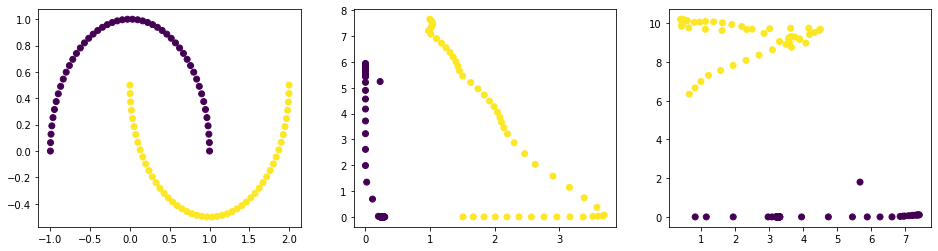

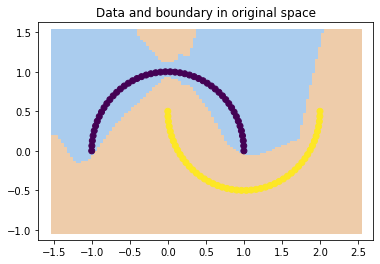

Epoch: 820......Loss: 0.0197
Epoch: 840......Loss: 0.0185
Epoch: 860......Loss: 0.0180
Epoch: 880......Loss: 0.0170
Epoch: 900......Loss: 0.0165
Epoch: 920......Loss: 0.0157
Epoch: 940......Loss: 0.0152
Epoch: 960......Loss: 0.0145
Epoch: 980......Loss: 0.0139


In [ ]:
moons_net = train(moons, moons_labels)

Epoch: 0......Loss: 0.6933
0


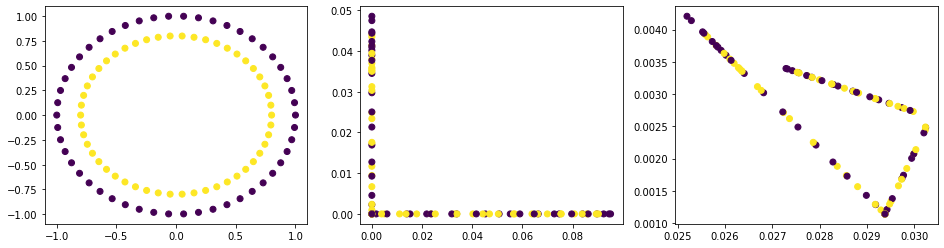

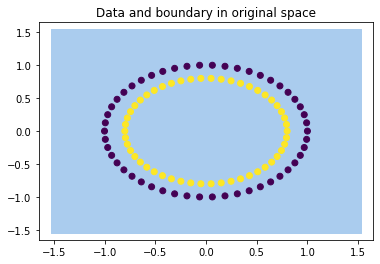

Epoch: 20......Loss: 0.6930
Epoch: 40......Loss: 0.6927
Epoch: 60......Loss: 0.6912
Epoch: 80......Loss: 0.6882
Epoch: 100......Loss: 0.6820
Epoch: 120......Loss: 0.6706
Epoch: 140......Loss: 0.6532
Epoch: 160......Loss: 0.6292
Epoch: 180......Loss: 0.5927
Epoch: 200......Loss: 0.5486
200


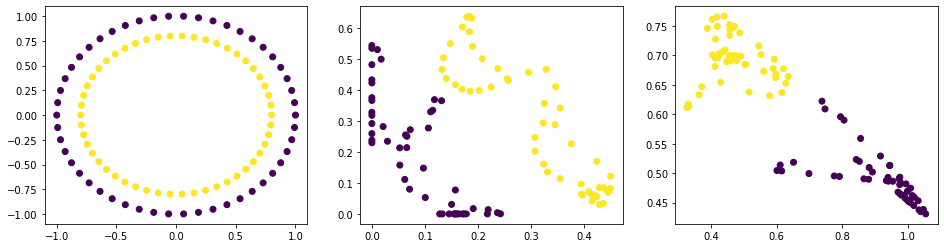

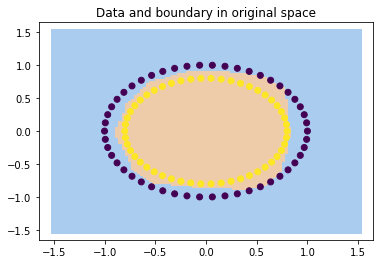

Epoch: 220......Loss: 0.5013
Epoch: 240......Loss: 0.4473
Epoch: 260......Loss: 0.3914
Epoch: 280......Loss: 0.3260
Epoch: 300......Loss: 0.2781
Epoch: 320......Loss: 0.2282
Epoch: 340......Loss: 0.1942
Epoch: 360......Loss: 0.1618
Epoch: 380......Loss: 0.1316
Epoch: 400......Loss: 0.1049
400


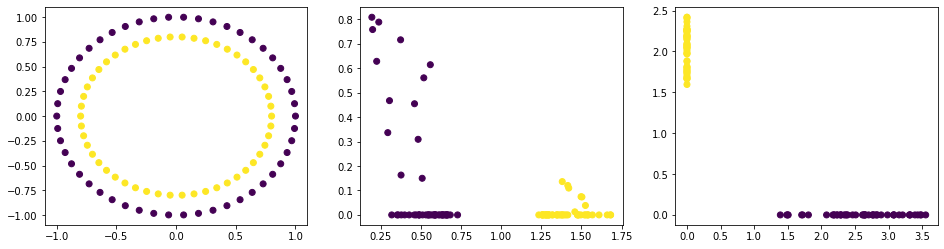

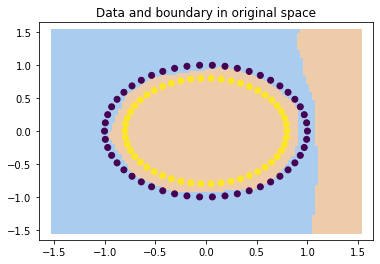

Epoch: 420......Loss: 0.0825
Epoch: 440......Loss: 0.0643
Epoch: 460......Loss: 0.0503
Epoch: 480......Loss: 0.0399
Epoch: 500......Loss: 0.0324
Epoch: 520......Loss: 0.0267
Epoch: 540......Loss: 0.0223
Epoch: 560......Loss: 0.0189
Epoch: 580......Loss: 0.0162
Epoch: 600......Loss: 0.0140
600


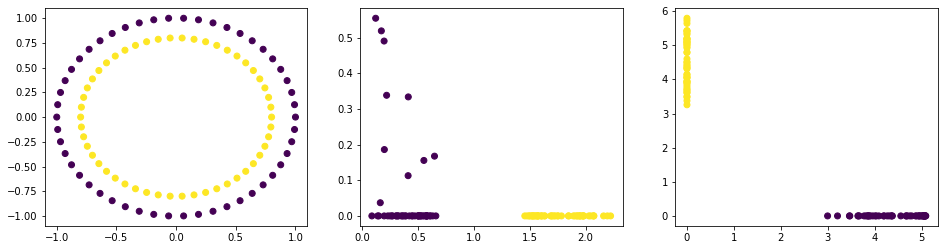

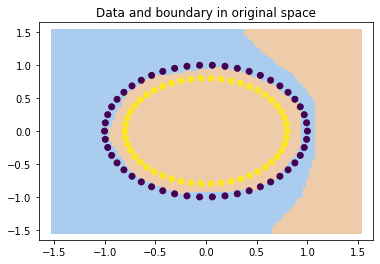

Epoch: 620......Loss: 0.0123
Epoch: 640......Loss: 0.0108
Epoch: 660......Loss: 0.0096
Epoch: 680......Loss: 0.0086
Epoch: 700......Loss: 0.0077
Epoch: 720......Loss: 0.0070
Epoch: 740......Loss: 0.0063
Epoch: 760......Loss: 0.0058
Epoch: 780......Loss: 0.0053
Epoch: 800......Loss: 0.0049
800


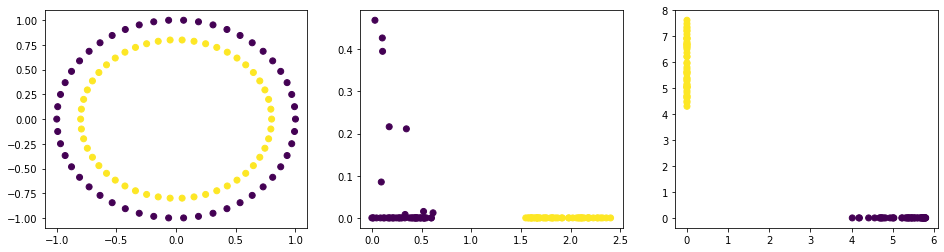

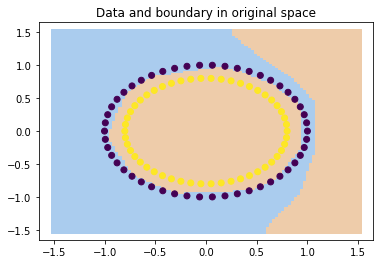

Epoch: 820......Loss: 0.0045
Epoch: 840......Loss: 0.0042
Epoch: 860......Loss: 0.0039
Epoch: 880......Loss: 0.0036
Epoch: 900......Loss: 0.0034
Epoch: 920......Loss: 0.0032
Epoch: 940......Loss: 0.0030
Epoch: 960......Loss: 0.0028
Epoch: 980......Loss: 0.0027


In [ ]:
circles_net2 = train(circles, circles_labels)

Epoch: 0......Loss: 0.6777
0


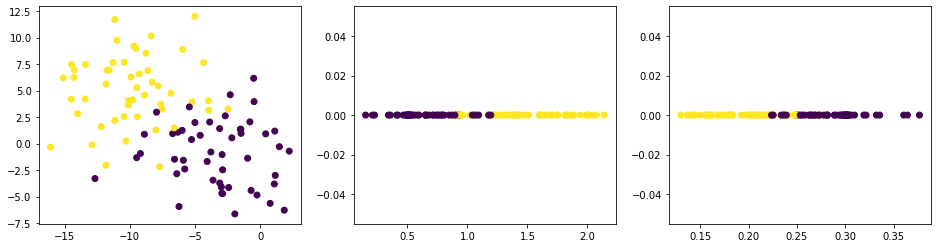

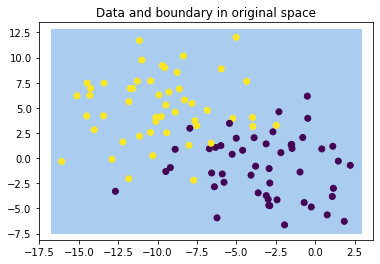

Epoch: 20......Loss: 0.6525
Epoch: 40......Loss: 0.6388
Epoch: 60......Loss: 0.6246
Epoch: 80......Loss: 0.6100
Epoch: 100......Loss: 0.5953
Epoch: 120......Loss: 0.5807
Epoch: 140......Loss: 0.5659
Epoch: 160......Loss: 0.5513
Epoch: 180......Loss: 0.5367
Epoch: 200......Loss: 0.5224
200


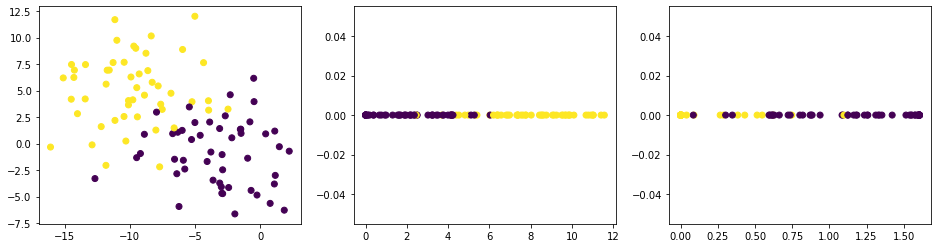

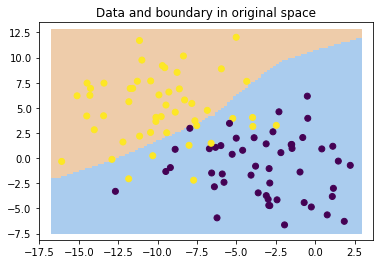

Epoch: 220......Loss: 0.5100
Epoch: 240......Loss: 0.4996
Epoch: 260......Loss: 0.4906
Epoch: 280......Loss: 0.4824
Epoch: 300......Loss: 0.4751
Epoch: 320......Loss: 0.4692
Epoch: 340......Loss: 0.4643
Epoch: 360......Loss: 0.4606
Epoch: 380......Loss: 0.4575
Epoch: 400......Loss: 0.4543
400


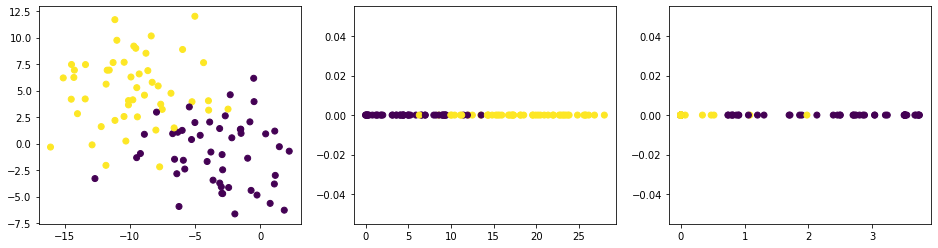

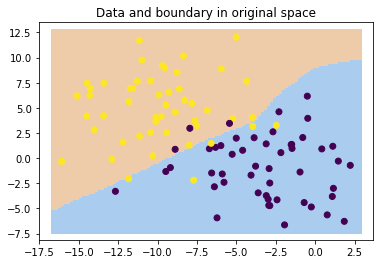

Epoch: 420......Loss: 0.4517
Epoch: 440......Loss: 0.4497
Epoch: 460......Loss: 0.4478
Epoch: 480......Loss: 0.4466
Epoch: 500......Loss: 0.4453
Epoch: 520......Loss: 0.4443
Epoch: 540......Loss: 0.4434
Epoch: 560......Loss: 0.4425
Epoch: 580......Loss: 0.4415
Epoch: 600......Loss: 0.4397
600


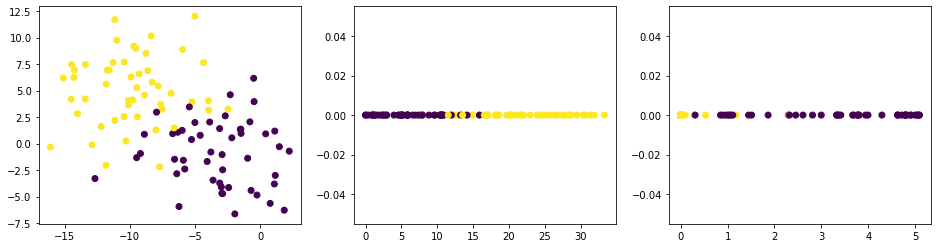

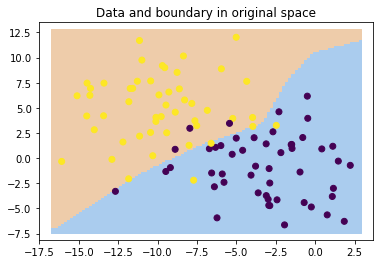

Epoch: 620......Loss: 0.4383
Epoch: 640......Loss: 0.4370
Epoch: 660......Loss: 0.4363
Epoch: 680......Loss: 0.4358
Epoch: 700......Loss: 0.4347
Epoch: 720......Loss: 0.4345
Epoch: 740......Loss: 0.4333
Epoch: 760......Loss: 0.4326
Epoch: 780......Loss: 0.4322
Epoch: 800......Loss: 0.4303
800


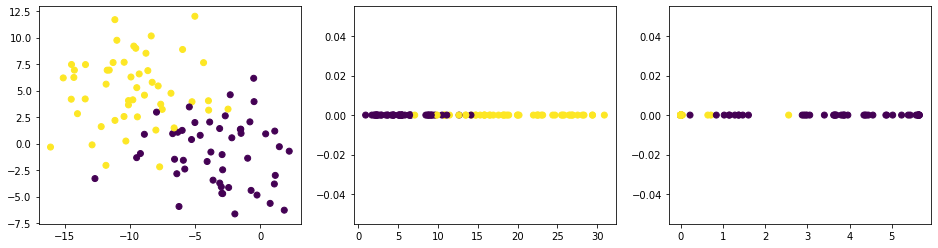

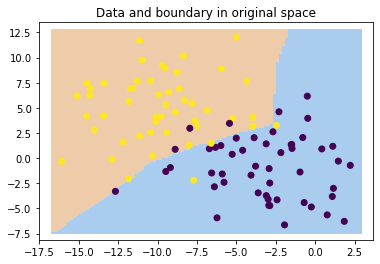

Epoch: 820......Loss: 0.4305
Epoch: 840......Loss: 0.4294
Epoch: 860......Loss: 0.4292
Epoch: 880......Loss: 0.4284
Epoch: 900......Loss: 0.4289
Epoch: 920......Loss: 0.4278
Epoch: 940......Loss: 0.4270
Epoch: 960......Loss: 0.4263
Epoch: 980......Loss: 0.4257
Epoch: 1000......Loss: 0.4251
1000


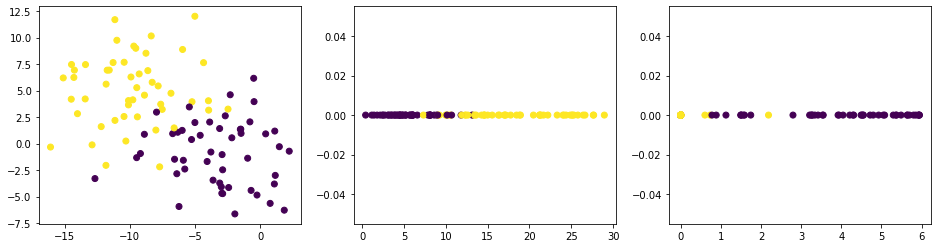

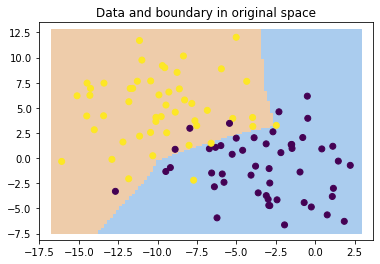

Epoch: 1020......Loss: 0.4245
Epoch: 1040......Loss: 0.4239
Epoch: 1060......Loss: 0.4232
Epoch: 1080......Loss: 0.4225
Epoch: 1100......Loss: 0.4218
Epoch: 1120......Loss: 0.4211
Epoch: 1140......Loss: 0.4204
Epoch: 1160......Loss: 0.4196
Epoch: 1180......Loss: 0.4189
Epoch: 1200......Loss: 0.4183
1200


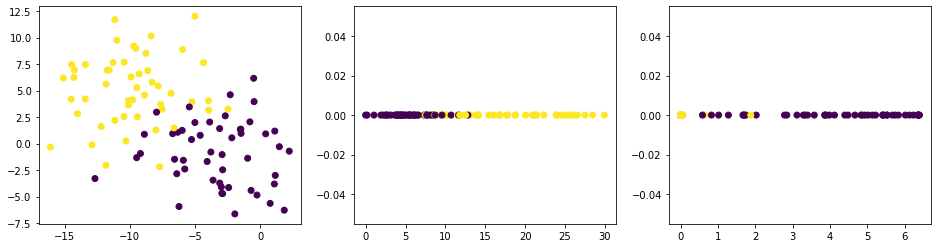

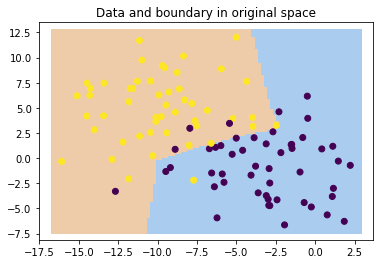

Epoch: 1220......Loss: 0.4174
Epoch: 1240......Loss: 0.4167
Epoch: 1260......Loss: 0.4159
Epoch: 1280......Loss: 0.4153
Epoch: 1300......Loss: 0.4145
Epoch: 1320......Loss: 0.4139
Epoch: 1340......Loss: 0.4129
Epoch: 1360......Loss: 0.4121
Epoch: 1380......Loss: 0.4113
Epoch: 1400......Loss: 0.4107
1400


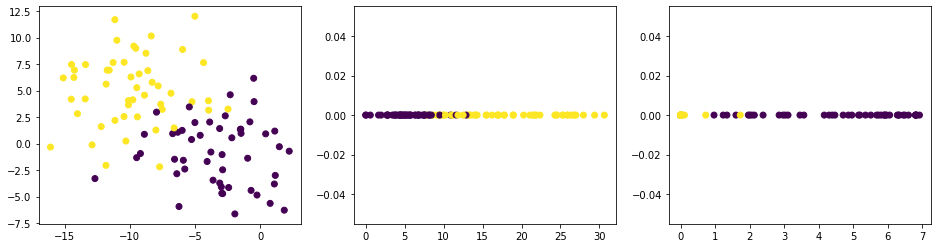

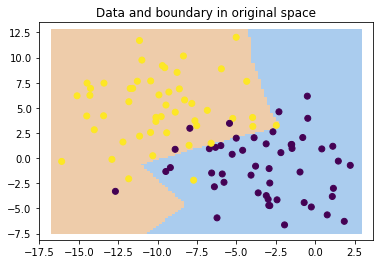

Epoch: 1420......Loss: 0.4097
Epoch: 1440......Loss: 0.4089
Epoch: 1460......Loss: 0.4080
Epoch: 1480......Loss: 0.4075
Epoch: 1500......Loss: 0.4068
Epoch: 1520......Loss: 0.4058
Epoch: 1540......Loss: 0.4052
Epoch: 1560......Loss: 0.4043
Epoch: 1580......Loss: 0.4032
Epoch: 1600......Loss: 0.4027
1600


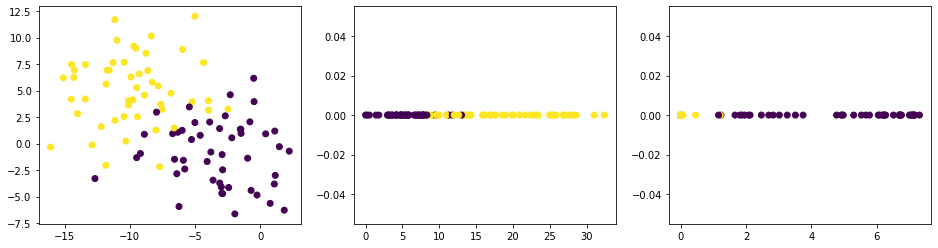

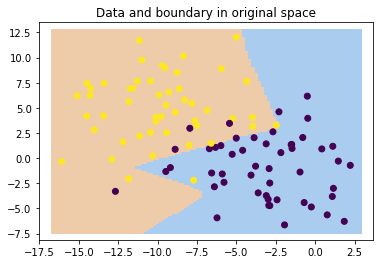

Epoch: 1620......Loss: 0.4026
Epoch: 1640......Loss: 0.4017
Epoch: 1660......Loss: 0.4007
Epoch: 1680......Loss: 0.4001
Epoch: 1700......Loss: 0.3994
Epoch: 1720......Loss: 0.3995
Epoch: 1740......Loss: 0.3987
Epoch: 1760......Loss: 0.3976
Epoch: 1780......Loss: 0.3979
Epoch: 1800......Loss: 0.3972
1800


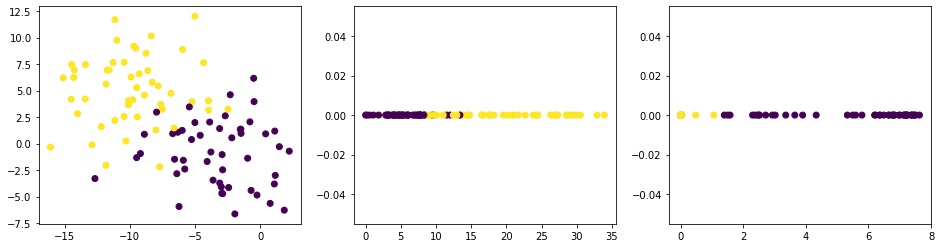

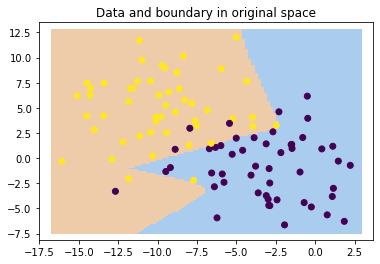

Epoch: 1820......Loss: 0.3985
Epoch: 1840......Loss: 0.3948
Epoch: 1860......Loss: 0.3940
Epoch: 1880......Loss: 0.3935
Epoch: 1900......Loss: 0.3903
Epoch: 1920......Loss: 0.3914
Epoch: 1940......Loss: 0.3901
Epoch: 1960......Loss: 0.3877
Epoch: 1980......Loss: 0.3886


In [ ]:
blobs_net2 = train(blobs, blobs_labels, epochs=2000)